<a href="https://colab.research.google.com/github/BishalBiswal/Improved-brain-tumour-classification-using-ViT/blob/main/resnet50_vitb32bnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

Epoch [1/20], Loss: 1.3012, Accuracy: 0.4025
Validation Loss: 1.0683, Accuracy: 0.5568
Epoch [2/20], Loss: 0.9284, Accuracy: 0.6285
Validation Loss: 0.8328, Accuracy: 0.6895
Epoch [3/20], Loss: 0.7128, Accuracy: 0.7404
Validation Loss: 0.7014, Accuracy: 0.7231
Epoch [4/20], Loss: 0.6028, Accuracy: 0.7855
Validation Loss: 0.5897, Accuracy: 0.7780
Epoch [5/20], Loss: 0.5142, Accuracy: 0.8158
Validation Loss: 0.5404, Accuracy: 0.8085
Epoch [6/20], Loss: 0.4588, Accuracy: 0.8382
Validation Loss: 0.4770, Accuracy: 0.8261
Epoch [7/20], Loss: 0.4029, Accuracy: 0.8571
Validation Loss: 0.4572, Accuracy: 0.8391
Epoch [8/20], Loss: 0.3764, Accuracy: 0.8634
Validation Loss: 0.4106, Accuracy: 0.8444
Epoch [9/20], Loss: 0.3387, Accuracy: 0.8799
Validation Loss: 0.4071, Accuracy: 0.8589
Epoch [10/20], Loss: 0.3207, Accuracy: 0.8855
Validation Loss: 0.3615, Accuracy: 0.8757
Epoch [11/20], Loss: 0.2869, Accuracy: 0.8965
Validation Loss: 0.3130, Accuracy: 0.8848
Epoch [12/20], Loss: 0.2770, Accuracy: 0.

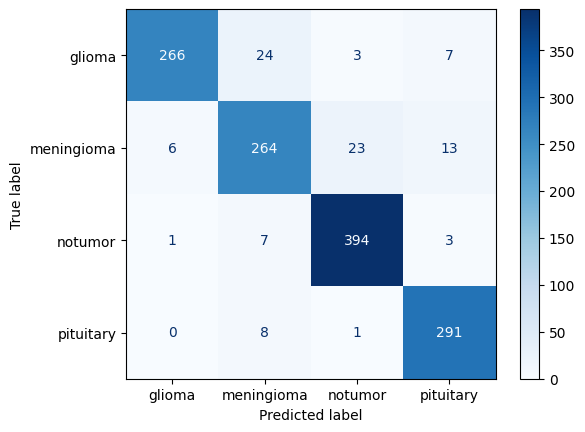

Validation Accuracy: 0.9268
              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.87      0.86      0.87       306
     notumor       0.94      0.97      0.95       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



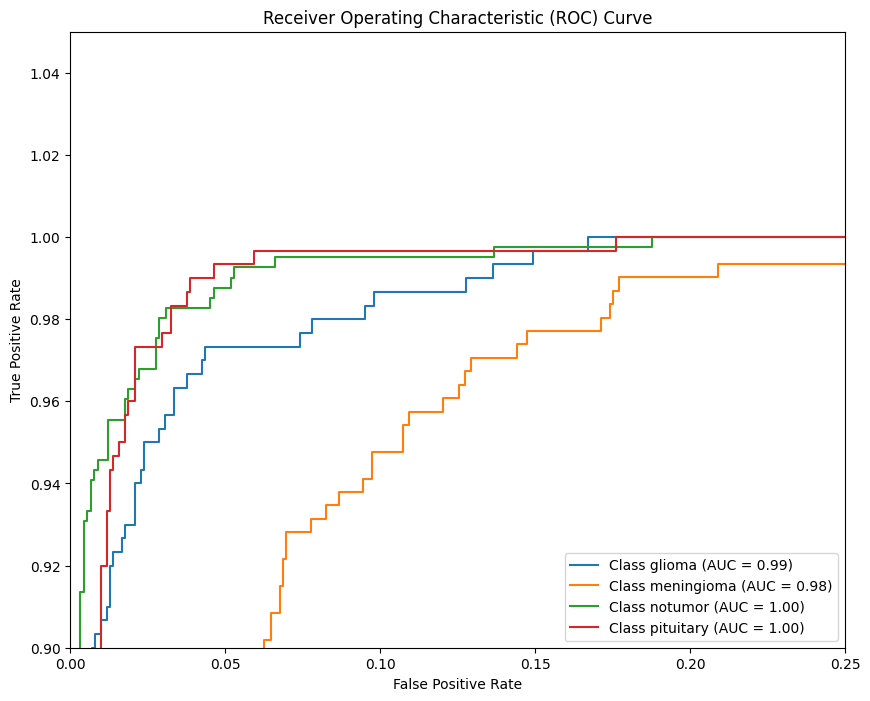

In [ ]:
!pip install timm
!pip install scikit-learn

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import timm

# Define data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jittering
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Random resized crop
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/content/drive/MyDrive/archive(1)'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create a custom model with Batch Normalization
class CustomResNeXt(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomResNeXt, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])  # Exclude the last FC layer
        self.bn = nn.BatchNorm1d(pretrained_model.fc.in_features)
        self.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Load pre-trained ResNeXt model and customize it
pretrained_model = timm.create_model('resnext50_32x4d', pretrained=True)
model = CustomResNeXt(pretrained_model, len(train_dataset.classes))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 20
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait if validation loss doesn't improve
counter = 0  # Counter to track the number of epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

print("Training complete.")

# Compute and plot confusion matrix
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = nn.functional.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=train_dataset.classes)
print(f'Validation Accuracy: {accuracy:.4f}')
print(report)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in y_true], [prob[i] for prob in y_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(train_dataset.classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.25])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
